[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1g9mzGYElAY-Ziya9vbV9VLUXdcKm26Pe#scrollTo=Sx9PzYSP4yoy)

# Introduction
AiZynthFinder is an open-source synthesis planning software.
It uses a template-based approach, using an Monte Carlo Tree Search (MCTS) algorithm to search for candidate precursors and then filtering them out using a Neural policy network to predict promising synthetic routes for a starting molecule.
This tutorial will contain a brief introduction to retrosynthesis and a guide on using AiZynthFinder to set up batch screenings.

# What is Retrosynthesis?
Retrosynthesis is the stepwise deconstruction of a chemical molecule into its commercially available precursors. It is a vital aspect of synthetic chemistry, and it allows chemists to build their molecules and maximize the yield efficiently. To perform retrosynthesis of a molecule, a chemist uses a set of guiding principles and an exhaustive knowledge of chemical reactions to pick a suitable transformation that breaks down the molecule. Choosing the correct conversion to break down the molecule requires understanding various reaction constraints like chemical validity, yield, and practical feasibility.


<figure>
<p align="center">
  <img src= "https://chembam.files.wordpress.com/2020/05/asp-1.png" />
</p>
</figure>
<h1 align="center"> A Single step Retrosynthesis</h1>



The above figure demonstrates how a starting molecule on the left (Aspirin) is
broken down into its synthons i.e molecules (2) and (3). The synthons are just hypothetical molecules which are created to show the electron transfer on breaking a bond. Since Oxygen is more electronegative than Carbon, it ends up with the negative charge and a forward reaction would involve a nucleophilic attack (electron transfer) by the oxygen atom on the carbon in the carbonyl group. From the synthons, appropriate synthetic equivalents (precursors) are constructed i.e molecules (4): phenolic acid and (5): methyl anhydride

Automating a complex decision-making process such as retrosynthesis is a challenging computational problem. Many AI-driven approaches to the problem exist and have been categorized broadly as template-free or template-based methods.

# How does AiZynthFinder work? 
AiZynthFinder uses the MCTS procedure to search for promising synthetic pathways. It uses templates to represent a disconnection.
MCTS is a 4 stage iterative algorithm typically employed in sequential decision making problems, and a brief explanation of the stages in context of retrosynthesis is provided below.


## What are templates anyway?
Templates are atom-mapped sequences that serve as a pattern for the model to recognize and incorporate into the molecule. Once the template is applied to the molecule, it gets broken down into its corresponding synthetic equivalents, which translates to one step of breaking down the target molecule. The model has to repeat this process on these synthetic equivalents to break them further down until a suitable precursor from the stocks is obtained. Choosing which template to apply at each stage is non-trivial, and this decision is taken by a Neural Network that ranks the templates for consideration in a search.


<figure>
<p align="center">
  <img src="https://drive.google.com/uc?id=1gabKWwSa4AUxzzProYatkymvjelGiOsA" />
</p>
</figure>
<h1 align="center"> An example template</h1>

<figure>
<p align="center">
  <img src="https://drive.google.com/uc?id=171GLP8olQnUeNo3g3bFGq5zrJEldtv8A" />
  
</p>
</figure>
<h1 align="center"> Template applied to an example reaction</h1>

Here we see that the template serves as the rule for performing a disconnection at a Nitrogen atom next to a carbonyl group. The reaction shown in the above figure matches this template(N11 of the molecule is N4 in the template), and hence the C1 - N11 bond is disconnected, leaving us with the two synthetic equivalents.

# Monte Carlo Tree Search Algorithm

Dishing out the complete retrosynthesis of a molecule is a decision-making problem. In each step, the decision of which bond to disconnect in the target molecule is taken. A successful retrosynthesis of a molecule requires optimal choices for each intermediate molecule formed.

A common way to obtain solutions to a decision-making problem is the Monte Carlo Tree Search algorithm (MCTS). The retrosynthesis for a  molecule is “solved” if the search algorithm can fully/partially decompose the molecule into candidates. Candidate molecules are usually commercially available precursors, and a set of possible candidates exist in a stock database. The default stock provided by AiZynthFinder is the Zinc database; this can be changed to a custom database using the configuration file.

<figure>
<p align="center">
  <img src="https://drive.google.com/uc?id=1bya2qbxTsQj6Hp7vFnyODIJ7hiyfL6Xl" />
</p>
</figure>
<h1 align="center"> MCTS Stages Ref:[2]</h1>






MCTS operates in a 4 stage iterative procedure, namely the Selection, Expansion, Rollout, and Backpropagation stages. To recast retrosynthesis as a tree search problem, we build a tree rooted at the starting molecule. Each child node represents a set of either precursors or intermediate molecules that get broken down. In the first iteration, the root node is expanded into child nodes by applying templates recommended by the template policy network and are rolled out. A rollout is executed to estimate how beneficial it is to continue breaking down the molecule with the applied template. The templates recommended by the expansion network may not represent reactions practically “in-scope.” Hence, an additional filter network is often used to predict the most likely transformations.


<figure>
<p align="center">
  <img src="https://drive.google.com/uc?id=1cPlQicADzg0Uy5tIdIt-KrjbfHSlQNRz" />
</p>
</figure>
<h1 align="center"> Template recommender. Ref:[1]</h1>


 In successive iterations, the tree is traversed using the Upper Confidence Bound (UCB) statistics to select the most promising leaf node, which is expanded further if it's non-terminal. If the leaf node is terminal, the search stops, and the score of the leaf node is backpropagated along the traversed path. The backpropagation step updates the statistics of the search tree, propagating the score of the leaf node up the tree. Each root to terminal leaf path represents a successful retrosynthetic route, and one can think of the edges connecting the nodes as the reactions which build up the molecule from its precursors. Different models can be used for the Expansion, Filter, and Rollout policy networks (3N MCTS). AiZynthFinder uses the same model for the exapansion and rollout and uses an additional filter policy, and hence it is a 2N MCTS, which benefits from quicker inferences.
 
<figure>
<p align="center">
  <img src="https://drive.google.com/uc?id=1vi6dqlDEDy9znw3jlfybiSJ10rZYMoap" />
</p>
</figure>
<h1 align="center"> Example Architecture used for the policy networks</h1>



# Setting up AiZynthFinder
Run the code below to setup the GUI for the app. Enter the SMILES for the molecule and select the number of iterations to run the search algorithm for.
We shall pick Cimetidine (SMILES: CC1=C(N=CN1)CSCCNC(=NC)NC#N) a drug for peptic ulcer treatment.

## Installation
We shall install the current latest release of the package (v3.4.0) from GitHub.
Note the Pillow version has to be locked to 9.0 as the existing installation on colab does not support the GUI interface. This requires restarting the runtime on colab when prompted.
We shall also use the provided model data and default stocks for the configuration file from the repo.



In [ ]:
!curl --location --silent bit.ly/rdkit-colab | tar xz -C /
!pip install --quiet graphviz
!pip install --quiet https://github.com/MolecularAI/aizynthfinder/archive/refs/tags/v3.4.0.tar.gz
!pip install --ignore-installed Pillow==9.0.0
!mkdir --parents data && download_public_data data

     / 716 kB 3.2 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     \ 135 kB 4.0 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133 kB 8.2 MB/s 
     |████████████████████████████████| 297 kB 52.8 MB/s 
     |████████████████████████████████| 508 kB 31.5 MB/s 
     |████████████████████████████████| 3.1 MB 56.8 MB/s 
     |████████████████████████████████| 40 kB 4.6 MB/s 
     |████████████████████████████████| 308 kB 55.2 MB/s 
     |████████████████████████████████| 585 kB 60.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 209 kB 37.7 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 64.8 MB/s 
     |█████████

uspto_model.hdf5: 100% 300M/300M [00:12<00:00, 24.0MB/s]
uspto_templates.hdf5: 100% 44.6M/44.6M [00:02<00:00, 17.7MB/s]
zinc_stock.hdf5: 100% 663M/663M [00:24<00:00, 26.6MB/s]
uspto_filter_model.hdf5: 100% 50.4M/50.4M [00:02<00:00, 18.5MB/s]
Configuration file written to config.yml


In [ ]:
#@title Start Graphical Interface {display-mode: "form"}

from rdkit.Chem.Draw import IPythonConsole
from aizynthfinder.interfaces import AiZynthApp
application = AiZynthApp("./data/config.yml")

Loading template-based expansion policy model from /content/data/uspto_model.hdf5 to uspto
Loading templates from /content/data/uspto_templates.hdf5 to uspto
Loading filter policy model from /content/data/uspto_filter_model.hdf5 to uspto
Loading stock from /content/data/zinc_stock.hdf5 to zinc
Selected as molecule cost: zero


Text(value='', continuous_update=False, description='SMILES')

Output(layout=Layout(border='1px solid silver', height='180px', width='50%'))

Output(layout=Layout(border='1px solid silver', height='320px', overflow='auto', width='99%'))

Output(layout=Layout(border='1px solid silver', width='99%'))

# Using the Python interface
This offers us a bit more flexibility and allows us to peek into the finer details of how the algorithms are implemented. As shown later in tutorial, it also offers a variety of built-in analysis helpers which can be used to extract more information about the routes and rank them with different scores.

The finder object of the AiZynthFinder class is the public API to access the methods which are running under the hood. We shall repeatedly use this object to query/compute different aspects of our retrosynthesis.


In [ ]:
from aizynthfinder.aizynthfinder import AiZynthFinder
filename = "./data/config.yml"
finder = AiZynthFinder(configfile=filename)

We can specify the stock database and the models for our configuration file, the default keras model provided is chosen for now for both the filter and expansion policies.


In [ ]:
finder.stock.select("zinc")
finder.expansion_policy.select("uspto")
finder.filter_policy.select("uspto")


In [ ]:
finder.target_smiles = "Cc1cccc(c1N(CC(=O)Nc2ccc(cc2)c3ncon3)C(=O)C4CCS(=O)(=O)CC4)C"
tsearch = finder.tree_search(show_progress=True)
print(f"Search completed in: {tsearch: 0.3f}s")


Search completed in:  125.128s


We can extract useful statistics from the completed tree search as follows: 

In [ ]:
finder.build_routes()
finder.extract_statistics()

{'first_solution_iteration': 9,
 'first_solution_time': 24.415492296218872,
 'is_solved': True,
 'max_children': 16,
 'max_transforms': 7,
 'number_of_nodes': 229,
 'number_of_precursors': 3,
 'number_of_precursors_in_stock': 3,
 'number_of_routes': 47,
 'number_of_solved_routes': 12,
 'number_of_steps': 2,
 'policy_used_counts': {'uspto': 228},
 'precursors_availability': 'zinc;zinc;zinc',
 'precursors_in_stock': 'O=C(O)C1CCS(=O)(=O)CC1, Cc1cccc(C)c1NCC(=O)O, Nc1ccc(-c2ncon2)cc1',
 'precursors_not_in_stock': '',
 'profiling': {'expansion_calls': 203, 'reactants_generations': 1958},
 'search_time': 125.12764382362366,
 'target': 'Cc1cccc(C)c1N(CC(=O)Nc1ccc(-c2ncon2)cc1)C(=O)C1CCS(=O)(=O)CC1',
 'top_score': 0.994039853898894}

AiZynthFinder also allows us to access the expansion and filter models directly using the AiZynthExpander class. This can be used to perform an expansion from a given molecule directly.

In [ ]:
from aizynthfinder.aizynthfinder import AiZynthExpander

filename = "./data/config.yml"
expander = AiZynthExpander(configfile=filename)
expander.expansion_policy.select("uspto")
expander.filter_policy.select("uspto")
reactions = expander.do_expansion("Cc1cccc(c1N(CC(=O)Nc2ccc(cc2)c3ncon3)C(=O)C4CCS(=O)(=O)CC4)C")



# Post processing tools

The AiZynthFinder library also provides a number of useful helpers to process the tree search. It allows scoring the different routes using different heuristics and even permits one to extend and add a custom scoring method. It also provides a method to cluster the different routes from a collection based on recursive application of chemical similarity matching.


Let us first look at the expansions obtained from the previous step. We can extract the reaction metadata and store it in a pandas dataframe for ease of usage. On displaying the first few suggestions from the expansion policy, we can see the different factors used for ranking such as the policy probability, feasibility. We can also look at the template applied for each reaction from the SMARTS string.

In [ ]:
import pandas as pd
metadata = []
for reaction_tuple in reactions:
    for reaction in reaction_tuple:
        metadata.append(reaction.metadata)
df = pd.DataFrame(metadata)
df

,template_hash,classification,library_occurence,policy_probability,policy_probability_rank,policy_name,template_code,template,feasibility,expansion_rank,smarts
0,993a80a34f6acdc22e1630fbdadc440460d93877c75dd1...,N-acylation to amide,2677,0.9015,0,uspto,28049,([C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:...,0.995227,1,([C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:...
1,3c2f9ebaf4afd5ac92b5ac7c3ff0ba51ecfcd4d148a3c3...,N-acylation to amide,1961,0.0250,2,uspto,10971,([C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:...,0.999978,2,([C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:...
2,f477a6f7ba6b7278f95a816f6daf14bd2b182a1174df7e...,Oxidations at sulfur,159,0.0091,3,uspto,44611,([C:2]-[S;H0;D4;+0:3](-[C:4])(=[O;H0;D1;+0:1])...,0.995792,3,([C:2]-[S;H0;D4;+0:3](-[C:4])(=[O;H0;D1;+0:1])...
3,7b09093072807311541947abe2dd3ac645654b47b71e1d...,Oxidations at sulfur,68,0.0025,4,uspto,22566,([C:1]-[S;H0;D4;+0:2](-[C:3])(=[O;H0;D1;+0])=[...,0.246933,4,([C:1]-[S;H0;D4;+0:2](-[C:3])(=[O;H0;D1;+0])=[...
4,0401a09c7a8e8335fc054a7cf7478da4eb776c8af14724...,Oxidations at sulfur,84,0.0021,5,uspto,755,([C:2]-[S;H0;D4;+0:3](-[C:4])(=[O;H0;D1;+0:1])...,0.253367,5,([C:2]-[S;H0;D4;+0:3](-[C:4])(=[O;H0;D1;+0:1])...


We can cluster the reactions using either the Tree edit distance or using an LSTM, by default the tree edit distance approach is picked. The distance matrix 
$A$ is defined such that $a_{ij}$ is the distance between route $i$ and $j$.

Note: To use the LSTM model, path to the model checkpoints have to be specified.

In [ ]:
from aizynthfinder.analysis import RouteCollection
from aizynthfinder.analysis import TreeAnalysis

rc = finder.routes
rc.cluster(n_clusters=3)
rc.distance_matrix()

array([[0.        , 5.13316785, 5.66586593, 6.27132799, 2.33333333,
        4.44358974],
       [5.13316785, 0.        , 3.31073553, 3.92067787, 6.64953265,
        8.38671717],
       [5.66586593, 3.31073553, 0.        , 0.67255435, 4.74730188,
        8.47570768],
       [6.27132799, 3.92067787, 0.67255435, 0.        , 4.70237434,
        8.47570768],
       [2.33333333, 6.64953265, 4.74730188, 4.70237434, 0.        ,
        5.34453431],
       [4.44358974, 8.38671717, 8.47570768, 8.47570768, 5.34453431,
        0.        ]])

In [ ]:
rc

We can also visualise the top synthetic routes using the ```make_images()``` method. The top route per the scoring function can be displayed by:


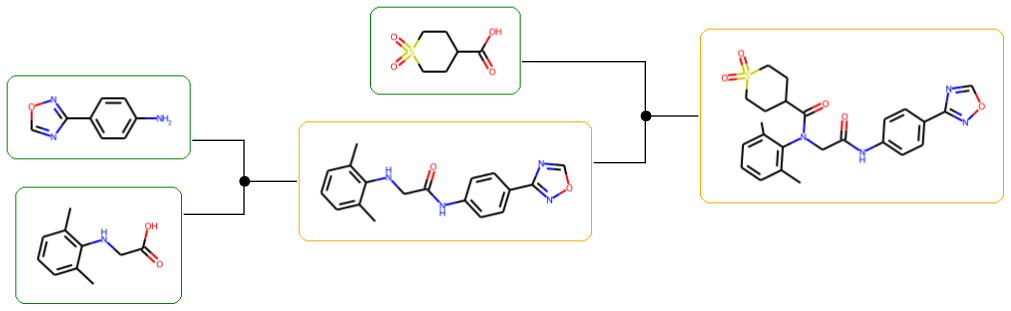

In [ ]:
rc.make_images()[0]

We can also create a combined tree, which is just the indvidual routes joined together. This can give us a big picture perspective of the different routes and gives us a rough idea about the number of steps each route takes.

We again use the route collection object to call the combined_reaction_tree() method. We then create a tar ball containing the images of the different molecule and create a VisJS HTML page to visualise the entire tree. The steps to extract the tar ball and display the tree in the IPython console are shown below. Use your mousewheel to zoom into the tree!

In [ ]:
ct = rc.combined_reaction_trees()
ct.to_visjs_page(filename="test1")

In [ ]:
!mkdir test1
!tar -C/content/test1 -xvf test1.tar 


./
./BXYVAIUGFYXLDY-UHFFFAOYSA-N.png
./DMOQHEWCUXULLO-UHFFFAOYSA-N.png
./DRFPPWNQAKQZBS-UHFFFAOYSA-N.png
./HFDUSGOMEIDXRN-UHFFFAOYSA-N.png
./IHAXEHHZVUDCHM-UHFFFAOYSA-N.png
./KGUZRMOXECFUGA-UHFFFAOYSA-N.png
./KOEIPRRACKGLRZ-UHFFFAOYSA-N.png
./LSTRKXWIZZZYAS-UHFFFAOYSA-N.png
./MNHNIVNAFBSLLX-UHFFFAOYSA-N.png
./PCBMYWORBGOYHM-UHFFFAOYSA-N.png
./RPJRJUVGGDVVDF-UHFFFAOYSA-N.png
./UFFBMTHBGFGIHF-UHFFFAOYSA-N.png
./VIMAISOQCSGKFW-UHFFFAOYSA-N.png
./route.html


In [ ]:
from IPython.display import HTML
HTML(open('./test1/route.html').read())

# References

1. Genheden S, Thakkar A, Chadimova V, et al (2020) AiZynthFinder: a fast, robust and flexible open-source software for retrosynthetic planning. J. Cheminf. https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00472-1
  -  Documentation : https://molecularai.github.io/aizynthfinder/
  -  Video demo of the package here: https://www.youtube.com/watch?v=r9Dsxm-mcgA
2. Segler MHS, Preuss M, Waller P (2018) Planning chemical syntheses with deep neural networks and symbolic AI. Nature 555:604–610. https://doi.org/10.1038/nature25978

3.  Heid, Esther, Jiannan Liu, Andrea Aude, and William H. Green. "Influence of Template Size, Canonicalization, and Exclusivity for Retrosynthesis and Reaction Prediction Applications." Journal of chemical information and modeling (2021).
4. https://chembam.files.wordpress.com/2020/05/asp-1.png 
